In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import glob
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ',  'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'UK'}

abbr_list=list(countries.values())

In [ ]:
fuels=['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat', 'Geothermal', 'Hydro Pumped Storage', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore']

In [15]:
import matplotlib.pyplot as plt 

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

In [3]:
import internal_inconsistencies as ii
import random

importing Jupyter notebook from internal_inconsistencies.ipynb
importing Jupyter notebook from data_preperation.ipynb


## Check total missing values

In [ ]:
# country = 'Belgium'
f = open('total missing values.txt','w')
for country,abbr in countries.items():
    df, length = ii.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False))
    df = df.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
    for column in df.columns.values:
        null_list = []
        for index, value in enumerate(df.loc[:, column]):
            if pd.isnull(value):
                null_list.append(index) 
        if len(null_list)>0:
            print(null_list)
            i=counter=0
            end = start = null_list[0]
            while i < len(null_list)-1:
                if null_list[i+1] - null_list[i] == 1:
                    end = null_list[i+1]
                    counter+=1
                else:
                    end = null_list[i]
                    # if start!=end:
                    print(f'{country} - {column} - from index {start} to index {end}')
                    f.write(f'{country} - {column} - from index {start} to index {end}\n')
                    start = null_list[i+1]
                i+=1
f.close()

## Fill missing values

In [4]:
def polynomial(selected_values,selected_index):
    X = np.array([i[0] for i in selected_values]).reshape(len(selected_values), 1)
    y = [i[1] for i in selected_values]
    y = [0 if pd.isna(x) else x for x in y]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

    degrees = np.arange(1, 11)
    min_rmse, min_deg = 1e10, 0

    for degree in degrees:

        # Preparing polynomial Train features based on x_train
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        x_poly_train = poly_features.fit_transform(x_train)

        # Polynomial linear regression based on train data
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Predicting y values and getting root mean squared error based on predicted y values and y_test values
        x_poly_test = poly_features.fit_transform(x_test)
        poly_predict = poly_reg.predict(x_poly_test)
        poly_mse = mean_squared_error(y_test, poly_predict)
        poly_rmse = np.sqrt(poly_mse)

        # Selecting the best degree of the polynimial function based on lowest root mean squared error
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = degree

    # Fitting the regression function again based on the selected best degree above
    poly_features = PolynomialFeatures(degree=min_deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    prediction = poly_reg.predict(poly_features.fit_transform([[selected_index]]))[0]
    if prediction<0:
        prediction = 0
    return(min_deg,prediction)

## DO NOT DELETE

In [11]:
# x = ['Germany', 'Spain', 'Greece', 'Hungary', 'Montenegro']
for i in range(9):
    globals()[f'counter_{i}'] =0
counter =0
f = open('neighbors of missing values.txt', 'w')
# for country,abbr in countries.items():
country='Belgium'
df, length = ii.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False).iloc[:,2:])
if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df.columns.values:
    df=df.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'],axis=1)
for column in df.columns.values:
    column_data = {}
    for index, value in enumerate(df.loc[:, column]):
        column_data[index] = value
    # null_values = [index for index,value in enumerate(df.loc[:,column]) if pd.isnull(df.loc[index,column])] #NEW

    for selected_index, selected_value in column_data.items():
        if pd.isnull(column_data[selected_index]) and selected_index in range(3*length, len(df[column])-3*length):
    
    # for selected_index in null_values:
    #     if selected_index in range(3*length, len(df[column])-3*length):
            selected_values = []
            for i in [x for x in range(-3,4) if x!=0]:
                selected_values.append([selected_index + i*length,column_data[selected_index + i*length]]) # Change df.loc with column_data
            if pd.isnull(selected_values).sum() >=3 and selected_index in range(27*length, len(df[column])-27*length):
                selected_values = []
                for i in [x for x in range(-3, 4) if x != 0]:
                    for j in [-24,0,24]:
                        selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])
                if pd.isnull(selected_values).sum() >= 12 and selected_index in range(51*length, len(df[column])-51*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-48,-24,0, 24,48]:
                            selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])
                    # print(selected_values)
                    if pd.isnull(selected_values).sum() >= 24 and pd.isnull(selected_values).sum() < len(selected_values):
                        prediction = np.mean(np.array([i[1] for i in selected_values]))
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                        counter_0 +=1
                    elif pd.isnull(selected_values).sum() < 24:
                        min_deg,prediction = polynomial(selected_values,selected_index)
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                        counter_1 +=1
                    else:
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{0}, Zero\n')
                        counter_2 +=1
                elif pd.isnull(selected_values).sum() >= 12:
                    prediction = np.mean(np.array([i[1] for i in selected_values]))
                    f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                    counter_3 +=1
                else:
                    min_deg,prediction = polynomial(selected_values,selected_index)
                    f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                    counter_4 +=1
            elif pd.isnull(selected_values).sum() >= 3:
                prediction = np.mean(np.array([i[1] for i in selected_values]))
                f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                counter_5 += 1
            else:
                min_deg,prediction = polynomial(selected_values, selected_index)
                f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                counter_6 +=1
        elif pd.isnull(column_data[selected_index]) and selected_index < 3*length: # Add pd.isnull(df.loc[selected_index]) and to the begining
            prediction = np.mean(np.array([column_data[i] for i in range(3*length)])) # Chnage df.loc with column_data[i]
            f.write(f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_7 +=1
        elif pd.isnull(column_data[selected_index]) and selected_index >= (len(df[column])-3*length): # Add pd.isnull(df.loc[selected_index]) and to the begining
            prediction = np.mean(np.array([column_data[i] for i in range(len(df[column])-3*length,len(df[column]))]))  # Chnage df.loc with column_data[i]
            f.write(f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_8 +=1
        # selected_weekly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(7*24*length,len(df[column])-7*24*length) and pd.isnull(value)]
        # counter3 += len(selected_weekly_column_data)
        # for selected_index,selected_value in selected_weekly_column_data:

            # if pd.isnull(column_data[selected_index]) and selected_index in range(7*24*length, len(df[column])-7*24*length):
            #     f.write(f'{country},{column},{selected_index},{(column_data[selected_index-7*24*length] + column_data[selected_index +7*24*length])/2} \n')
            # elif pd.isnull(column_data[selected_index]) and selected_index not in range(7*24*length, len(df[column])-7*24*length):
            #     f.write(f'{country},{column},{selected_index},{0} \n')

                # print(country, column, selected_index, selected_index-7*24*length, selected_index +7*24*length)
    # print(country,counter5)
for i in range(9):
    print(globals()[f'counter_{i}'])


917
1262
3
13
2167
28
601
2
0


In [ ]:
country = 'Bulgaria'
df_orig, length = ii.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False).iloc[:,2:])
if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
    df_orig=df_orig.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'],axis=1)
df_hourly = copy.deepcopy(df_orig)
df_weekly = copy.deepcopy(df_orig)
# selected_columns = [0]


In [ ]:
deleted_values=[]
# values_1 = np.random.randint(low=3, high=8757, size=50)
# for k in [0,10]:
#     for i in values_1:
#         for j in [i for i in range(-3, 4)]:
#             df.iloc[i+ j*length,k] = np.nan
#         deleted_values.append([i,k])

# values_2 = np.random.randint(low=0, high=8760, size=50)
# for k in [1,16]:
#     for i in values_2:
#         df.iloc[i,k] = np.nan
#         deleted_values.append([i,k])

# values_3 = np.random.randint(low=27, high=8733, size=50)
# for k in [3, 13]:
#     for i in values_3:
#         for j in [i for i in range(-3, 4)]:
#             for l in [-24,0,24]:
#                 df.iloc[i + (j+l)*length, k] = np.nan
#         deleted_values.append([i, k])

# values_4 = np.random.randint(low=51, high=8709, size=50)
# for k in [4, 17]:
#     for i in values_4:
#         for j in [i for i in range(-3, 4)]:
#             for l in [-48,-24, 0, 24,48]:
#                 df.iloc[i + (j+l)*length, k] = np.nan
#         deleted_values.append([i, k])

# values_5 = np.random.randint(low=27, high=8733, size=50)
# for k in [9, 19]:
#     for i in values_5:
#         for j in [i for i in range(-3, 4)]:
#             for l in [-24, 0,24]:
#                 df.iloc[i + (j+l)*length, k] = np.nan
#         deleted_values.append([i, k])

# values_6 = np.random.randint(low=51, high=8709, size=50)
# for k in [11]:
#     for i in values_6:
#         for j in [i for i in range(-3, 4)]:
#             for l in [-48, 0, 24]:
#                 df.iloc[i + (j+l)*length, k] = np.nan
#         deleted_values.append([i, k])
values = np.random.randint(low=0,high=8760*length/2,size=10000)
for value in values:
    x= random.choice(range(20))
    df_hourly.iloc[value, x] = np.nan
    df_weekly.iloc[value, x] = np.nan
    deleted_values.append([value,x])

values = np.random.randint(low=8760*length/2, high=8760*length, size=10000)
for value in values:
    x = random.choice(range(20))
    df_hourly.iloc[value, x] = np.nan
    df_weekly.iloc[value, x] = np.nan
    deleted_values.append([value, x])


In [ ]:
for i in range(11):
    globals()[f'counter_{i}'] = 0
f = open('neighbors of missing values.txt', 'w')
for column in df_hourly.columns.values:
    column_data = {}
    for index, value in enumerate(df_hourly.loc[:, column]):
        column_data[index] = value
    # selected_hourly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(3*length,len(df[column])-3*length) and pd.isnull(value)]
    # for selected_index,selected_value in selected_hourly_column_data:
    for selected_index, selected_value in column_data.items():
        if pd.isnull(column_data[selected_index]) and selected_index in range(3*length, len(df_hourly[column])-3*length):
            selected_values = []
            for i in [x for x in range(-3, 4) if x != 0]:
                selected_values.append(
                    [selected_index + i*length, column_data[selected_index + i*length]])
            if pd.isnull(selected_values).sum() >= 3 and selected_index in range(27*length, len(df_hourly[column])-27*length):
                selected_values = []
                for i in [x for x in range(-3, 4) if x != 0]:
                    for j in [-24, 0, 24]:
                        selected_values.append(
                            [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                if pd.isnull(selected_values).sum() >= 12 and selected_index in range(51*length, len(df_hourly[column])-51*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-48, -24, 0, 24, 48]:
                            selected_values.append(
                                [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                    # print(selected_values)
                    if pd.isnull(selected_values).sum() >= 24 and pd.isnull(selected_values).sum() < len(selected_values):
                        prediction = np.mean(
                            np.array([i[1] for i in selected_values]))
                        df_hourly.loc[selected_index, column] = prediction
                        f.write(
                            f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                        counter_0 += 1
                    elif pd.isnull(selected_values).sum() < 24:
                        min_deg, prediction = polynomial(
                            selected_values, selected_index)
                        df_hourly.loc[selected_index, column] = prediction
                        f.write(
                            f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                        counter_1 += 1
                    else:
                        df_hourly.loc[selected_index, column] = 0
                        f.write(
                            f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{0}, Zero\n')
                        counter_2 += 1
                elif pd.isnull(selected_values).sum() >= 12:
                    prediction = np.mean(
                        np.array([i[1] for i in selected_values]))
                    df_hourly.loc[selected_index, column] = prediction
                    f.write(
                        f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                    counter_3 += 1
                else:
                    min_deg, prediction = polynomial(
                        selected_values, selected_index)
                    df_hourly.loc[selected_index, column] = prediction
                    f.write(
                        f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                    counter_4 += 1
            elif pd.isnull(selected_values).sum() >= 3:
                prediction = np.mean(
                    np.array([i[1] for i in selected_values]))
                df_hourly.loc[selected_index, column] = prediction
                f.write(
                    f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                counter_5 += 1
            else:
                min_deg, prediction = polynomial(
                    selected_values, selected_index)
                df_hourly.loc[selected_index, column] = prediction
                f.write(
                    f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                counter_6 += 1
        elif pd.isnull(column_data[selected_index]) and selected_index < 3*length:
            prediction = np.mean(
                np.array([column_data[i] for i in range(3*length)]))
            df_hourly.loc[selected_index, column] = prediction
            f.write(
                f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_7 += 1
        elif pd.isnull(column_data[selected_index]) and selected_index >= (len(df_hourly[column])-3*length):
            prediction = np.mean(np.array(
                [column_data[i] for i in range(len(df_hourly[column])-3*length, len(df_hourly[column]))]))
            df_hourly.loc[selected_index, column] = prediction
            f.write(
                f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_8 += 1

        if pd.isnull(column_data[selected_index]) and selected_index in range(7*24*length, len(df_weekly[column])-7*24*length):
            df_weekly.loc[selected_index, column] = (column_data[selected_index-7*24*length] + column_data[selected_index +7*24*length])/2
            f.write(f'{country},{column},{selected_index},{(column_data[selected_index-7*24*length] + column_data[selected_index +7*24*length])/2} \n')
            counter_9 += 1
        
        elif pd.isnull(column_data[selected_index]) and selected_index not in range(7*24*length, len(df_weekly[column])-7*24*length):
            df_weekly.loc[selected_index, column] = 0
            f.write(f'{country},{column},{selected_index},{0} \n')
            counter_10 += 1

            # print(country, column, selected_index, selected_index-7*24*length, selected_index +7*24*length)
# print(country,counter5)
for i in range(11):
    print(globals()[f'counter_{i}'])


In [ ]:
df_hourly = df_hourly.replace(np.nan, 0)
df_orig = df_orig.replace(np.nan, 0)
df_weekly = df_weekly.replace(np.nan, 0)


In [ ]:
mse=0
y=[]
y_hourly_predict=[]
y_weekly_predict = []
x= []
for item in deleted_values:
    y.append(df_orig.iloc[item[0], item[1]])
    y_hourly_predict.append(df_hourly.iloc[item[0], item[1]])
    y_weekly_predict.append(df_weekly.iloc[item[0], item[1]])
    # print(old, new, abs(old-new)*100/old)
    # f.write(f'{y},{y_predict},{abs(y-y_predict)*100/y}\n')
    # mse += (old-new)**2
msqe1 = mean_squared_error(y, y_hourly_predict)
msqe2 = mean_squared_error(y, y_weekly_predict)
# print(mse/len(deleted_values), np.sqrt(mse/len(deleted_values)))
print(msqe1,msqe2)
print(sum(y), sum(y_hourly_predict), sum(y_weekly_predict))


In [ ]:
tot=0
x=df_orig.iloc[:].sum(axis=1).sum()
y = df_hourly.iloc[:].sum(axis=1).sum()
z = df_weekly.iloc[:].sum(axis=1).sum()
print((x-y)*100/x)
print((x-z)*100/x)


In [ ]:
f = open('neighbors of missing values.txt', 'w')
index=[i for i in range(8760)]
counter_1 =0
counter_2 = 0
for column in df_hourly.columns.values:
    for i in index:
        # if df_orig.loc[i, column] != df_hourly.loc[i, column]:
        #     print(df_orig.loc[i, column], df_hourly.loc[i, column])
        #     counter_1 += 1

        # if df_orig.loc[i, column] != df_weekly.loc[i, column]:
        #     print(df_orig.loc[i, column], df_weekly.loc[i, column])
        counter_2 += 1

        if abs(df_orig.loc[i, column] - df_hourly.loc[i, column]) > abs(df_orig.loc[i, column] - df_weekly.loc[i, column]):
            f.write(f'{i} , {column}\n')


## Column wise check what generation type suits hourly and which suits weekly

In [7]:
countries=['Belgium','Switzerland','Denmark','Finland','Latvia','Norway','Poland','Portugal','Slovakia','Slovenia']
f = open('neighbors of missing values.txt', 'w')
for country in countries:
    df_orig, length = ii.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False).iloc[:, 2:])
    if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
        df_orig = df_orig.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
    df_hourly = copy.deepcopy(df_orig)
    df_weekly = copy.deepcopy(df_orig)

    for column in df_orig.columns.values:

        deleted_values = []
        values = np.random.randint(low=0, high=8760*length, size=2920*length)
        for value in values:
            # x = random.choice(range(20))
            df_hourly.loc[value, column] = np.nan
            df_weekly.loc[value, column] = np.nan
            deleted_values.append([value, column])

        column_data = {}
        for index, value in enumerate(df_hourly.loc[:, column]):
            column_data[index] = value
        # selected_hourly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(3*length,len(df[column])-3*length) and pd.isnull(value)]
        # for selected_index,selected_value in selected_hourly_column_data:
        for selected_index in values:
            if selected_index in range(3*length, len(df_hourly[column])-3*length):
                selected_values = []
                for i in [x for x in range(-3, 4) if x != 0]:
                    selected_values.append(
                        [selected_index + i*length, column_data[selected_index + i*length]])
                if pd.isnull(selected_values).sum() >= 3 and selected_index in range(27*length, len(df_hourly[column])-27*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-24, 0, 24]:
                            selected_values.append(
                                [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                    if pd.isnull(selected_values).sum() >= 12 and selected_index in range(51*length, len(df_hourly[column])-51*length):
                        selected_values = []
                        for i in [x for x in range(-3, 4) if x != 0]:
                            for j in [-48, -24, 0, 24, 48]:
                                selected_values.append(
                                    [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                        # print(selected_values)
                        if pd.isnull(selected_values).sum() >= 24 and pd.isnull(selected_values).sum() < len(selected_values):
                            prediction = np.mean(
                                np.array([i[1] for i in selected_values]))
                            df_hourly.loc[selected_index, column] = prediction
 
                        elif pd.isnull(selected_values).sum() < 24:
                            min_deg, prediction = polynomial(
                                selected_values, selected_index)
                            df_hourly.loc[selected_index, column] = prediction
                            

                        else:
                            df_hourly.loc[selected_index, column] = 0
                            
                    elif pd.isnull(selected_values).sum() >= 12:
                        prediction = np.mean(
                            np.array([i[1] for i in selected_values]))
                        df_hourly.loc[selected_index, column] = prediction
                       

                    else:
                        min_deg, prediction = polynomial(
                            selected_values, selected_index)
                        df_hourly.loc[selected_index, column] = prediction
                        
                elif pd.isnull(selected_values).sum() >= 3:
                    prediction = np.mean(
                        np.array([i[1] for i in selected_values]))
                    df_hourly.loc[selected_index, column] = prediction
                   
                else:
                    min_deg, prediction = polynomial(
                        selected_values, selected_index)
                    df_hourly.loc[selected_index, column] = prediction
                   

            elif selected_index < 3*length:
                prediction = np.mean(
                    np.array([column_data[i] for i in range(3*length)]))
                df_hourly.loc[selected_index, column] = prediction
                

            elif selected_index >= (len(df_hourly[column])-3*length):
                prediction = np.mean(np.array(
                    [column_data[i] for i in range(len(df_hourly[column])-3*length, len(df_hourly[column]))]))
                df_hourly.loc[selected_index, column] = prediction
               

            if selected_index in range(7*24*length, len(df_weekly[column])-7*24*length):
                df_weekly.loc[selected_index, column] = (
                    column_data[selected_index-7*24*length] + column_data[selected_index + 7*24*length])/2

            elif selected_index not in range(7*24*length, len(df_weekly[column])-7*24*length):
                df_weekly.loc[selected_index, column] = 0


        # index = [i for i in range(8760*length)]
        counter_1 = 0
        for i in values:
            if abs(df_orig.loc[i, column] - df_hourly.loc[i, column]) > abs(df_orig.loc[i, column] - df_weekly.loc[i, column]):
                f.write(f'{country},{column},{i%24}\n')
                print(f'{country},{column},{i%24}\n')
        #         counter_1 += 1
        # if counter_1>0:
        #     f.write(f'{country} ,{column} , {counter_1*100/(2920*length)}\n')
        #     print(f'{country} ,{column} , {counter_1*100/(2920*length)}\n')
f.close()


Belgium,Biomass  - Actual Aggregated [MW],12

Belgium,Biomass  - Actual Aggregated [MW],6

Belgium,Biomass  - Actual Aggregated [MW],23

Belgium,Biomass  - Actual Aggregated [MW],5

Belgium,Biomass  - Actual Aggregated [MW],1

Belgium,Biomass  - Actual Aggregated [MW],2

Belgium,Biomass  - Actual Aggregated [MW],0

Belgium,Biomass  - Actual Aggregated [MW],3

Belgium,Biomass  - Actual Aggregated [MW],4

Belgium,Biomass  - Actual Aggregated [MW],16

Belgium,Biomass  - Actual Aggregated [MW],19

Belgium,Biomass  - Actual Aggregated [MW],12

Belgium,Biomass  - Actual Aggregated [MW],17

Belgium,Biomass  - Actual Aggregated [MW],14

Belgium,Biomass  - Actual Aggregated [MW],10

Belgium,Biomass  - Actual Aggregated [MW],7

Belgium,Biomass  - Actual Aggregated [MW],3

Belgium,Biomass  - Actual Aggregated [MW],1

Belgium,Biomass  - Actual Aggregated [MW],8

Belgium,Biomass  - Actual Aggregated [MW],10

Belgium,Biomass  - Actual Aggregated [MW],22

Belgium,Biomass  - Actual Aggregated [MW],11


In [10]:
df = pd.read_csv('temp.csv')
generations = list(set(df['Generation'].values))


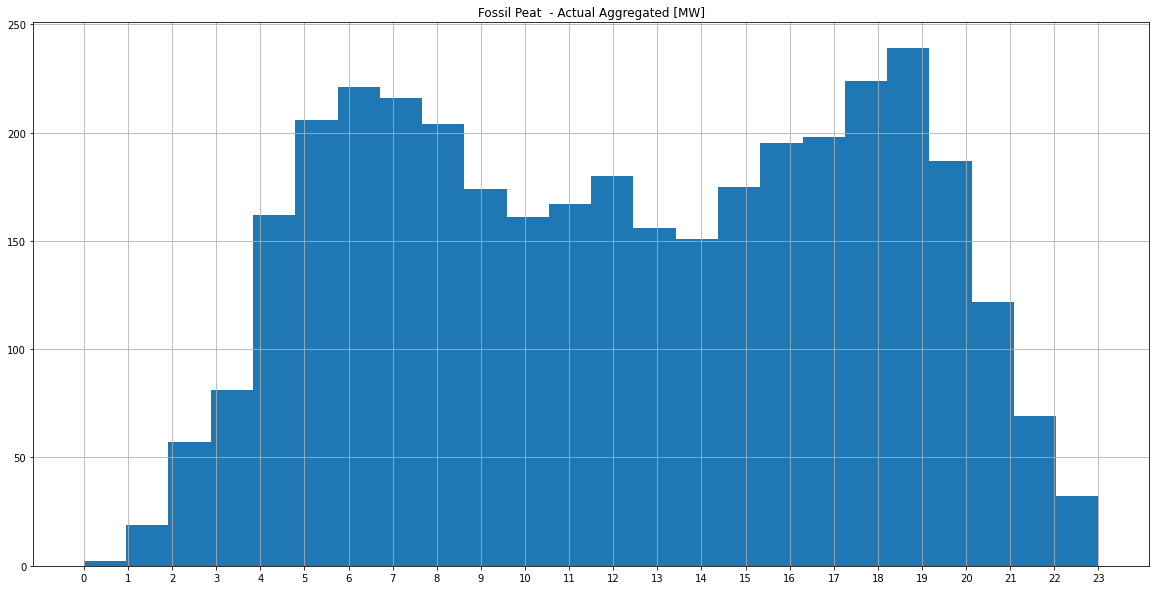

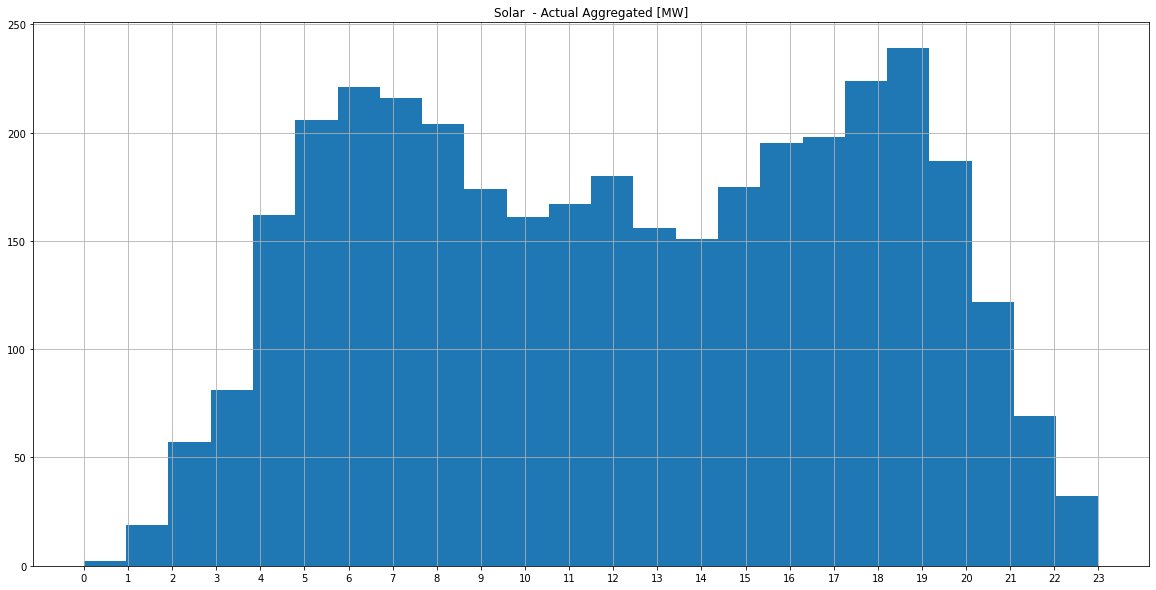

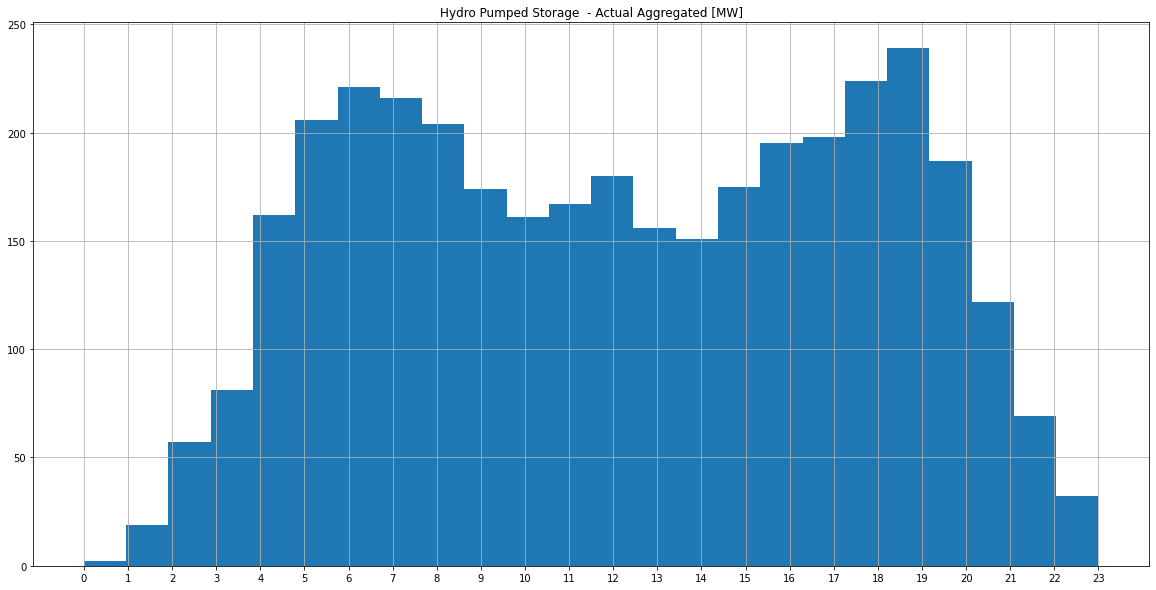

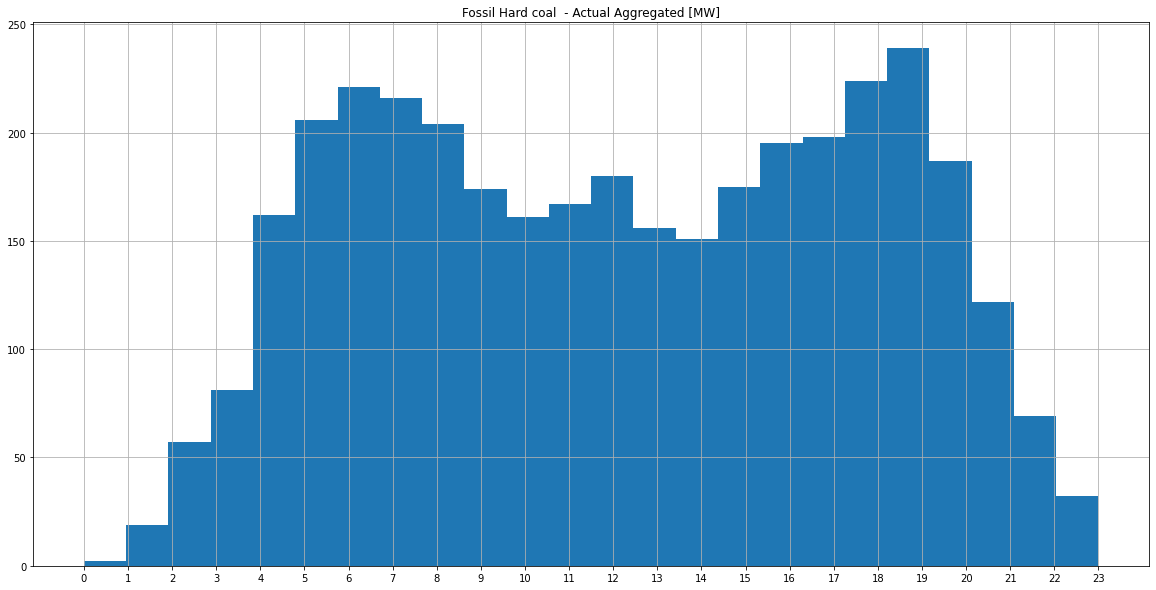

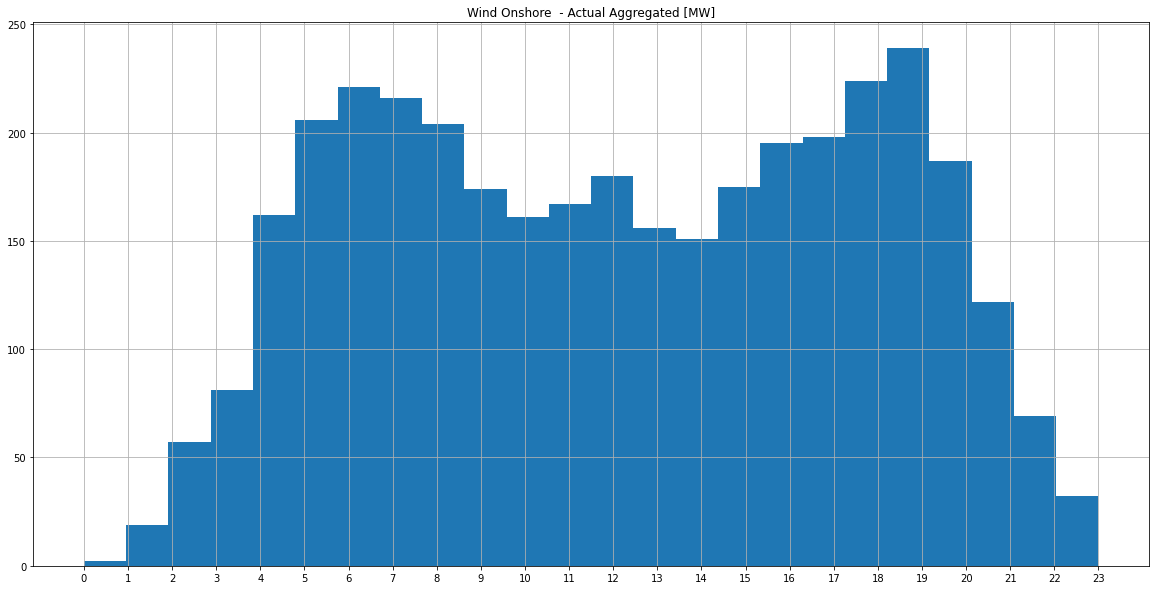

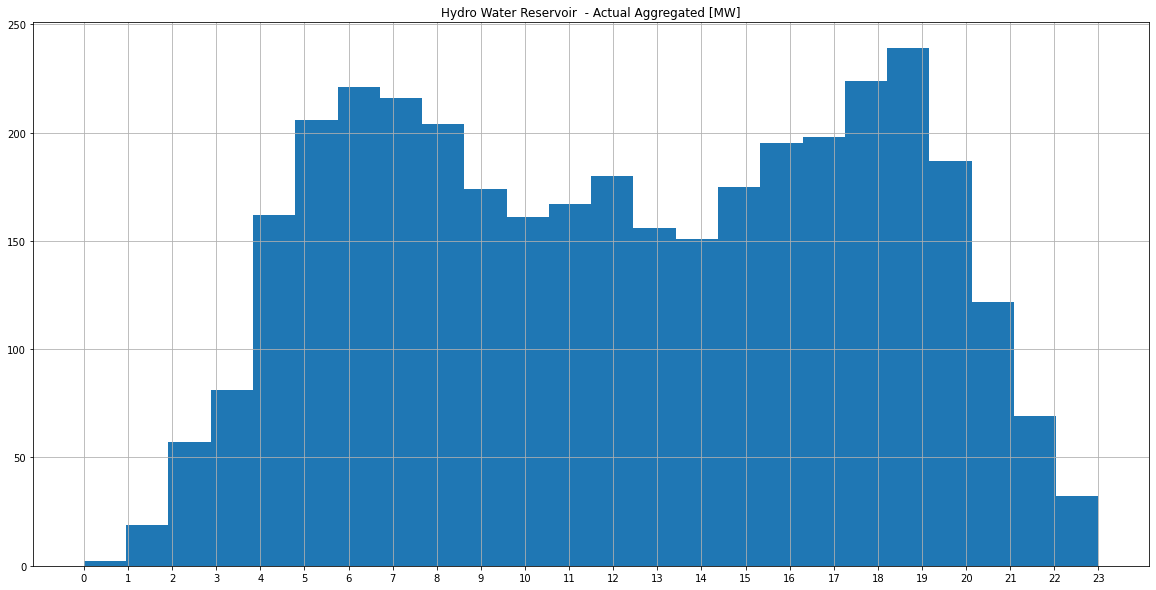

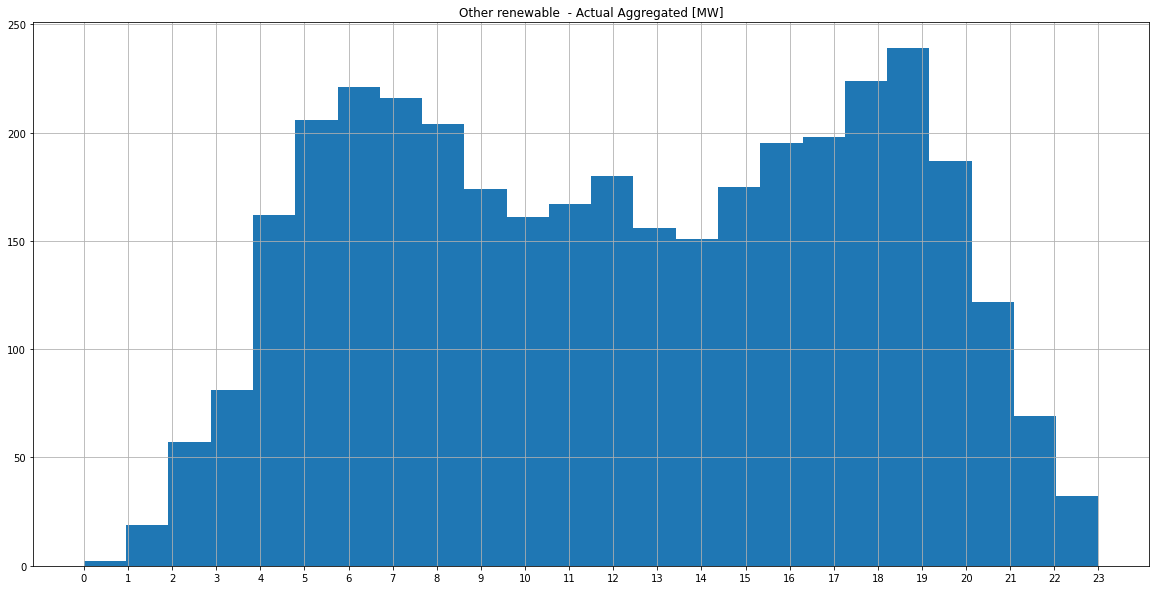

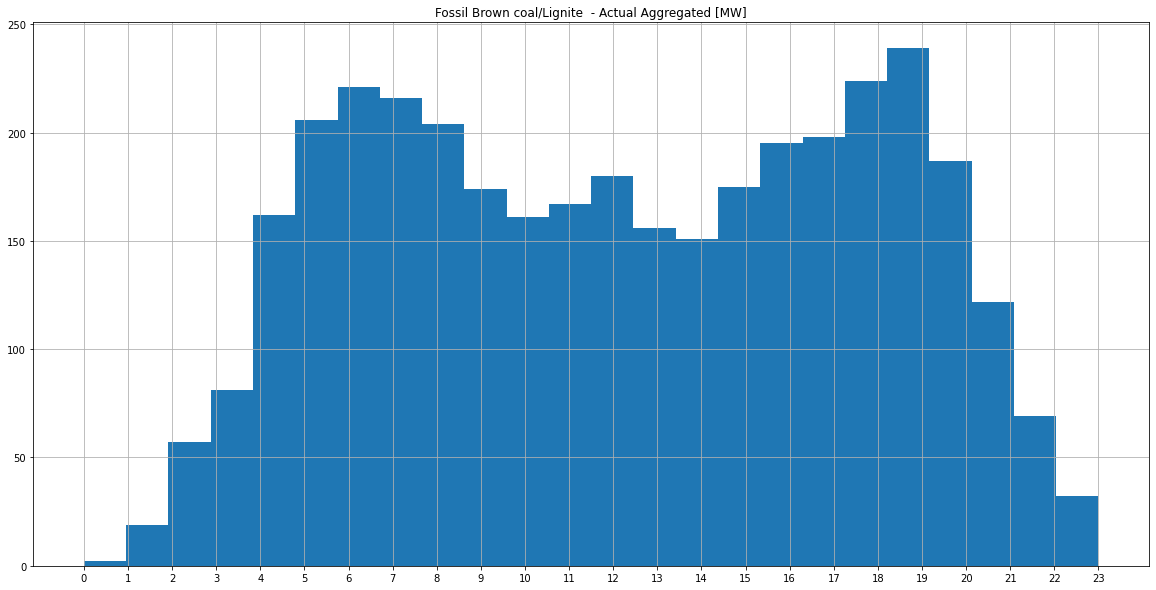

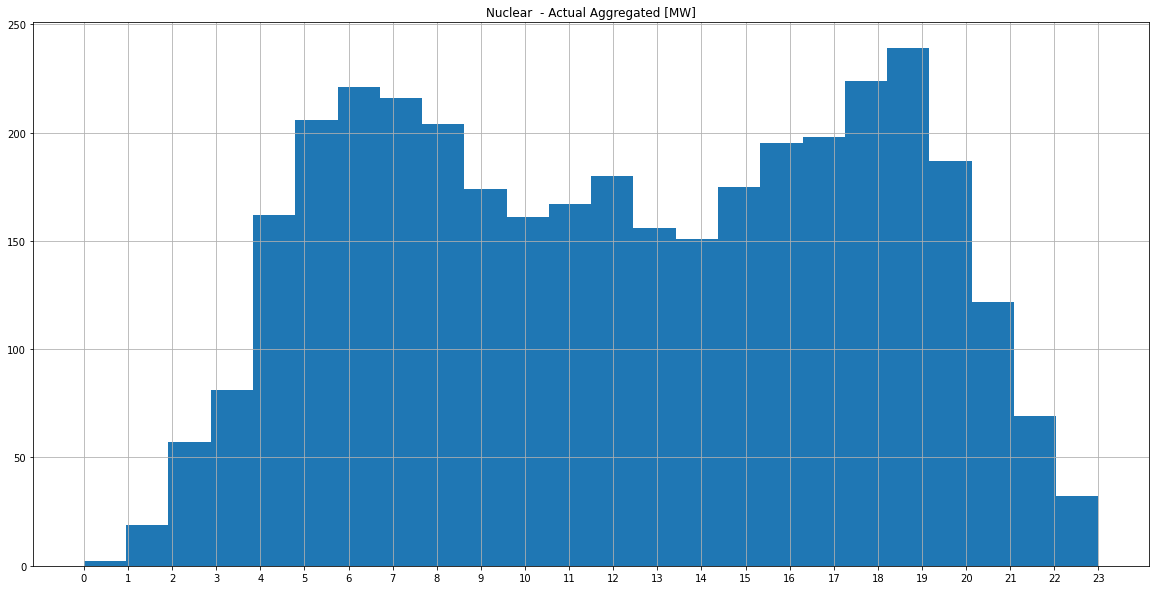

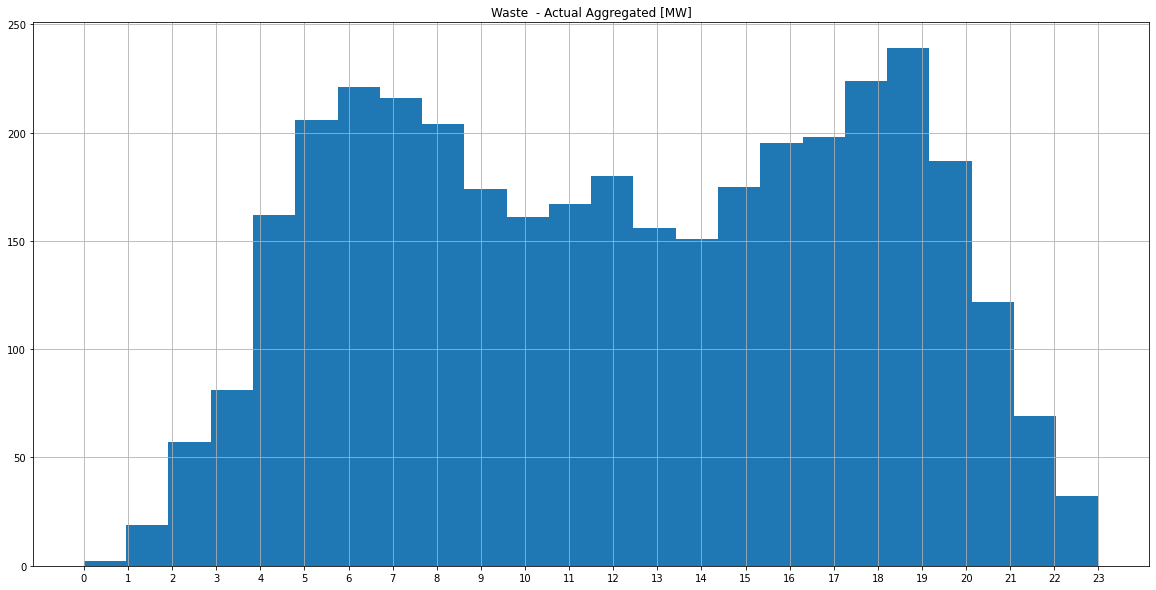

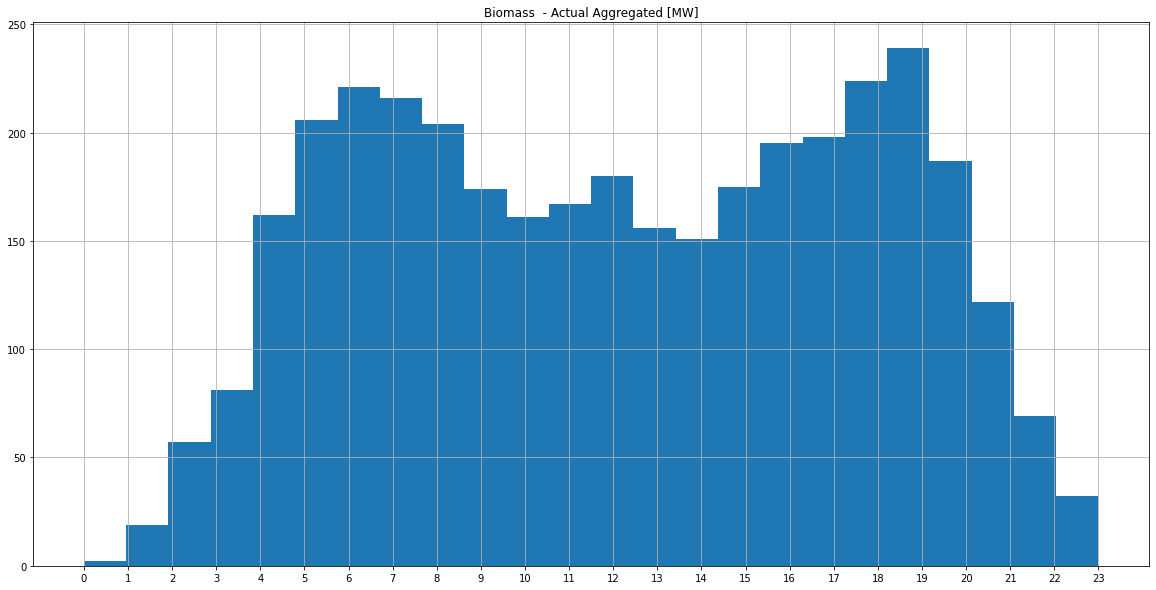

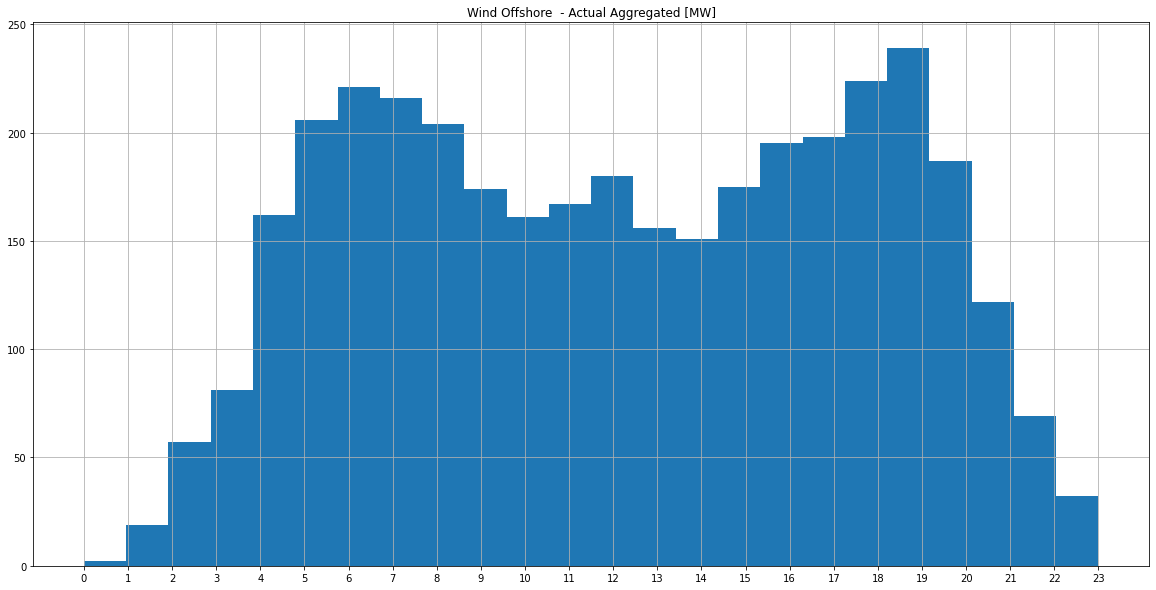

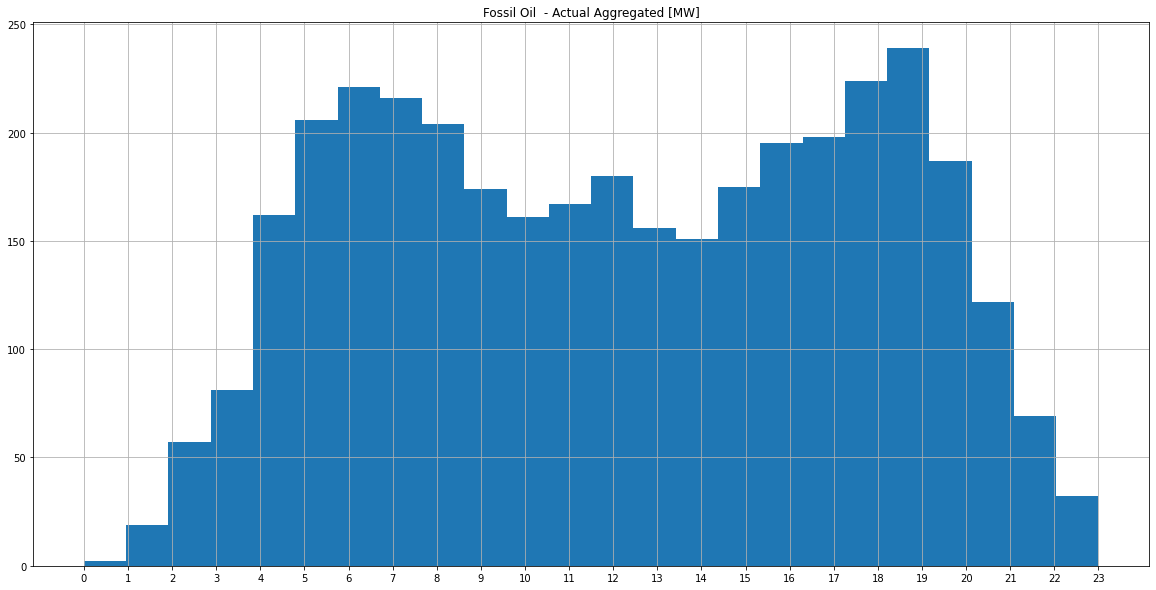

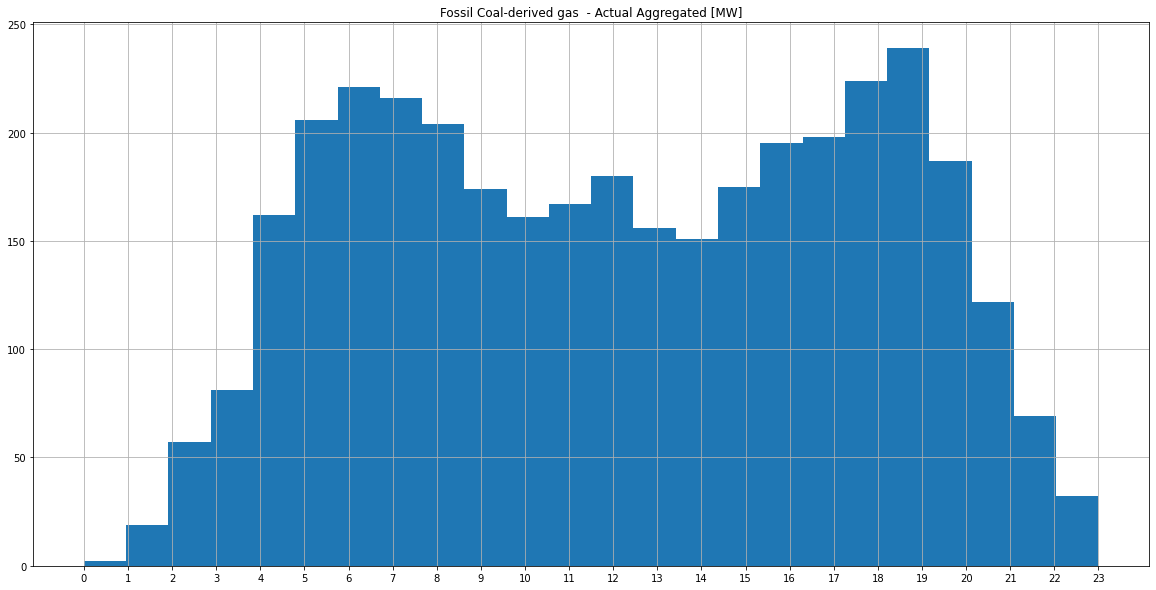

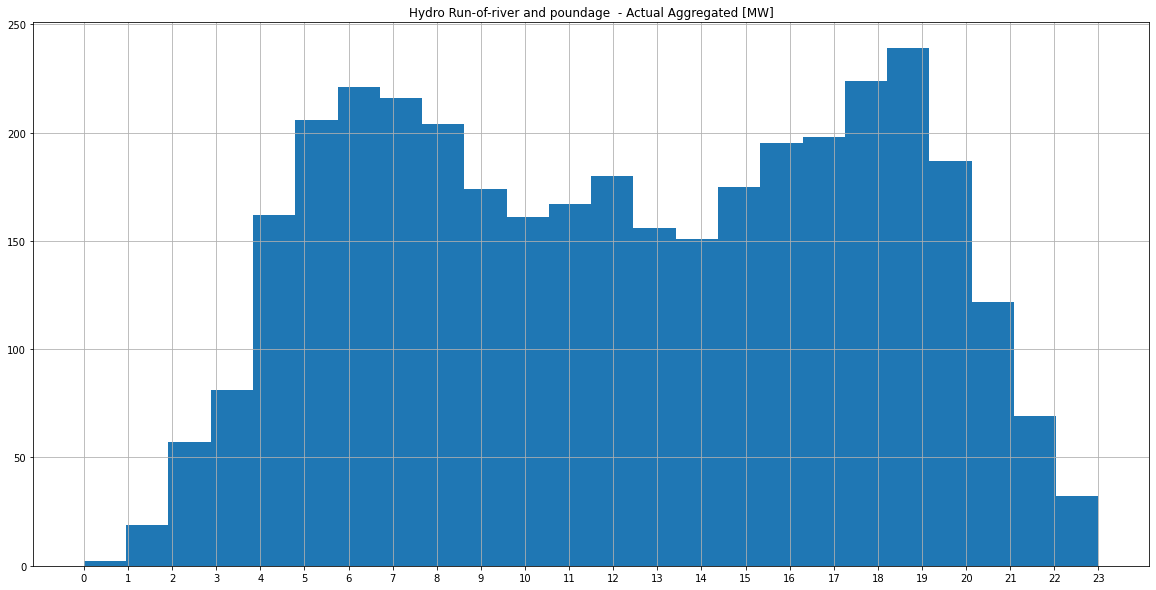

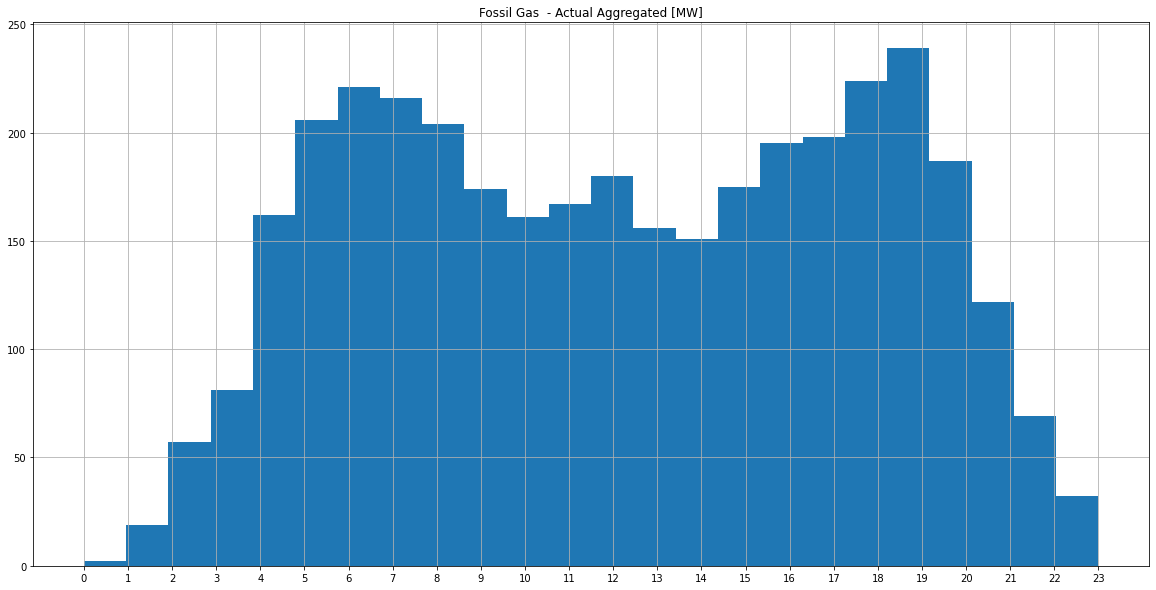

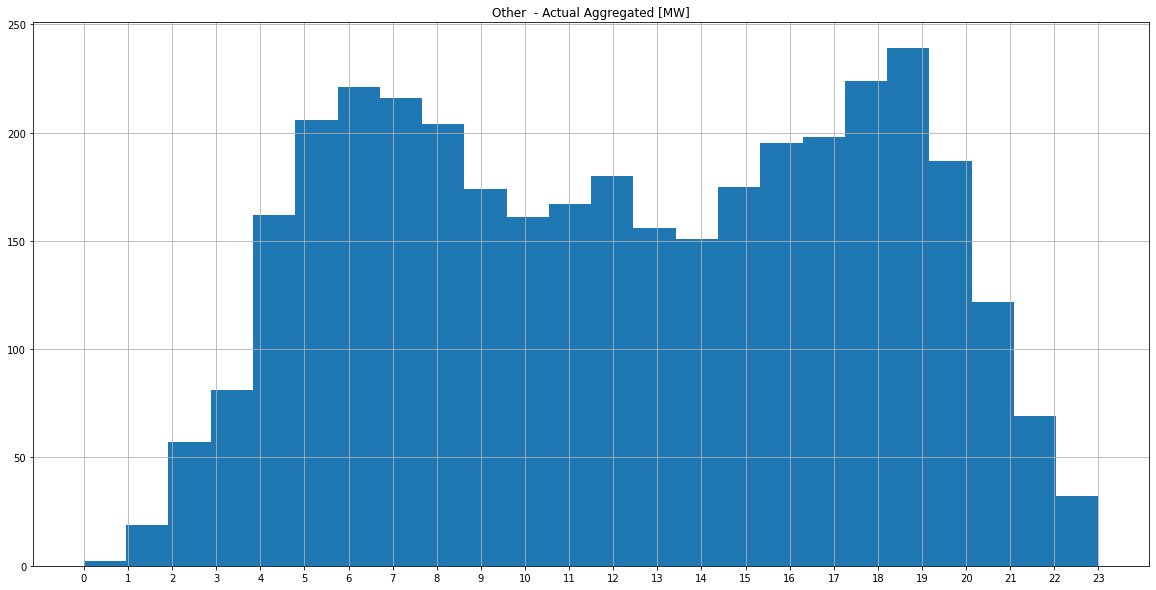

In [24]:
for generation in generations: 
    x = (df.loc[df['Generation'] == generation])['Time'].values
    plt.figure(figsize=(20, 10))
    plt.hist(x, bins=24)
    plt.grid()
    plt.title(generation)
    plt.xticks(range(24))
    plt.show()
